<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
# import piplite
# await piplite.install(['numpy'])
# await piplite.install(['pandas'])
# await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

# setting random seeds to have repricable results for decision tree
np.random.seed(0)

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict, name = 'test'):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(name + ' Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.savefig('./img/' + name + '.png')
    plt.show() 

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, X_train, X_test, Y_train, Y_test):
    '''Get model evaluation metrics on the train and test set.'''
    
    # hyperparameters scores
    best_est_ = model.best_estimator_
    best_par_ = model.best_params_
    accuracy_ = model.best_score_
    
    # test-train scores
    
    # get the model prediction
    y_predict_r = model.predict(X_test)
    
    train_score_ = model.score(X_train, Y_train)
    
    test_score_ = model.score(X_test, Y_test)    
    precision_ = precision_score(Y_test, y_predict_r)
    recall_ = recall_score(Y_test, y_predict_r)
    f1_ = f1_score(Y_test, y_predict_r)
        
    print("tuned hpyerparameters :(best parameters) ",best_par_)
    print("accuracy :",accuracy_)
    
    return best_est_, best_par_, accuracy_, train_score_, test_score_, precision_, recall_, f1_

The `calculate_metrics` function compute both model hyperparameters performances (`best_est`, `best_par`, `accuracy`) and prediction evaluations (`train_score`, `test_score`, `precision`, `recall`, `f1`). These metrics will be used to evaluate the different models with their pros and cons. In the following anaysis, a specific emphasis will be on the false positive score.

## Load the dataframe


Load the data

> The analysis performed in this notebook are based on the data sets produced in previous sections (notably [dataset_part_2.csv](https://github.com/pacoraggio/IBM-Applied-Data-Science-Capstone/blob/main/Notebooks/01_03_labs-jupyter-spacex-Data%20wrangling.ipynb) is the result of data wrangling after the collection phase and [data_set_part_3.csv](https://github.com/pacoraggio/IBM-Applied-Data-Science-Capstone/blob/main/Notebooks/02_02_jupyter-labs-eda-dataviz.ipynb) is the result of feature selection.

In [5]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
# resp1 = await fetch(URL1)
# text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(URL1)

In [6]:
print('The dataset contains {} rows and {} columns'.format(data.shape[0], data.shape[1]))
data.head()

The dataset contains 90 rows and 18 columns


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [7]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
# resp2 = await fetch(URL2)
# text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(URL2)

In [8]:
print('The dataset contains {} rows and {} columns'.format(X.shape[0], X.shape[1]))
X.head()

The dataset contains 90 rows and 83 columns


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [9]:
Y = data['Class']

In [10]:
type(Y)

pandas.core.series.Series

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [11]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3

Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [13]:
Y_test.shape[0]

18

### Checking if data are unbalanced

After splitting the test and train data, I am chacking that the balance between positive and negative examples in sets are preserved (it can happen that this balance can be lost especially when we have few examples).

In [14]:
Y.value_counts(normalize=True)

Class
1    0.666667
0    0.333333
Name: proportion, dtype: float64

The target variable contains about $66.6\text{%}$ of positive examples (i.e. succesfull landing) versus $33.3\text{%}$ of negative examples.

In [15]:
Y_train.value_counts(normalize=True)

Class
1    0.666667
0    0.333333
Name: proportion, dtype: float64

In [16]:
Y_test.value_counts(normalize=True)

Class
1    0.666667
0    0.333333
Name: proportion, dtype: float64

> As we can see, we have about $2/3$ of positive examples (succesfull launches) versus $1/3$ of negative ones (failures). This balance is preserved once we split the data.

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [18]:
lr=LogisticRegression()

In [19]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge

logreg_cv = GridSearchCV(lr,
                         parameters,
                         cv = 10
                        )

logreg_cv.fit(X,Y)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [20]:
best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1 = calculate_metrics(logreg_cv, X_train, X_test, Y_train, Y_test)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8222222222222222


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:

> This is done in the `calculate_metrics` function

In [21]:
print("train score: {}".format(np.round(train_score, 4)))
print("test score: {}".format(np.round(test_score, 4)))

train score: 0.875
test score: 0.9444


Lets look at the confusion matrix:


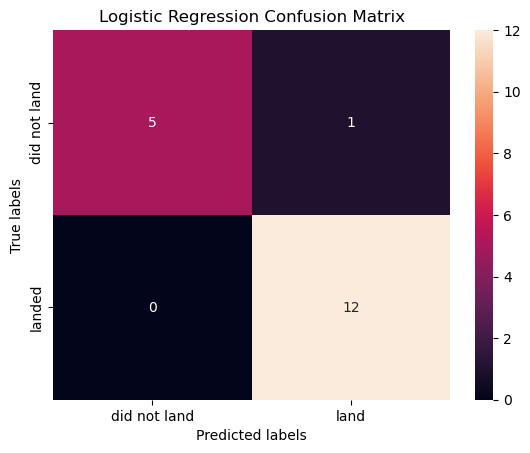

In [22]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat, name='Logistic Regression')

In [23]:
# display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
logreg_results = pd.DataFrame([[best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1]],
                          columns=['best estimator', 'best parameters', 'accuracy', 'train score', 'test score', 'precision', 'recall', 'f1 score'])
logreg_results.index = ['logistic regression']
logreg_results

,best estimator,best parameters,accuracy,train score,test score,precision,recall,f1 score
logistic regression,LogisticRegression(C=0.01),"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.822222,0.875,0.944444,0.923077,1.0,0.96


> Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. With Logistic Regression we have one false positive. In our analysis, we will enphasise the role of false positive as a highly important parameter. In fact, from a business perspective, predicting a succesfull launch that actually was a failure, has potentially the higher cost: we don't want to destroy a rocket that was predicted as a success. A false negative (i.e. a predicted failed misssion which might turn in a success) has less cost compared with the possibility of an actual failure. 

## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [24]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [25]:
svm_cv = GridSearchCV(svm, 
                      parameters, 
                      cv = 10)

svm_cv.fit(X, Y)
svm_cv.best_estimator_

SVC(gamma=0.03162277660168379, kernel='sigmoid')

In [26]:
best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1 = calculate_metrics(svm_cv, X_train, X_test, Y_train, Y_test)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8222222222222223


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [27]:
print("train score: {}".format(np.round(train_score, 4)))
print("test score: {}".format(np.round(test_score, 4)))

train score: 0.8611
test score: 0.9444


We can plot the confusion matrix


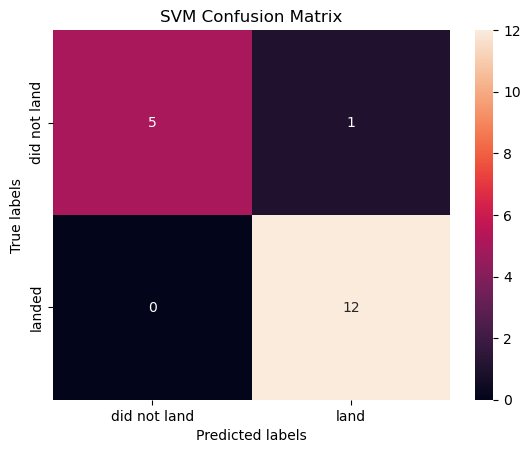

In [28]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat, name = 'SVM')

In [29]:
svm_results_df = pd.DataFrame([[best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1]],
                          columns=['best estimator', 'best parameters', 'accuracy', 'train score', 'test score', 'precision', 'recall', 'f1 score'])
svm_results_df.index = ['svm']
svm_results_df

,best estimator,best parameters,accuracy,train score,test score,precision,recall,f1 score
svm,"SVC(gamma=0.03162277660168379, kernel='sigmoid')","{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.822222,0.861111,0.944444,0.923077,1.0,0.96


> SVM model have same predictive results as Logistic Regression (test score, precision, recall and f1 score).

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [30]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [31]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning 

tree_cv = GridSearchCV(tree, parameters, cv = 10)
tree_cv.fit(X, Y)
tree_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=4, splitter='random')

## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [32]:
best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1 = calculate_metrics(tree_cv, X_train, X_test, Y_train, Y_test)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.8666666666666668


In [33]:
print("train score: {}".format(np.round(train_score, 4)))
print("test score: {}".format(np.round(test_score, 4)))

train score: 0.8611
test score: 0.8333


We can plot the confusion matrix


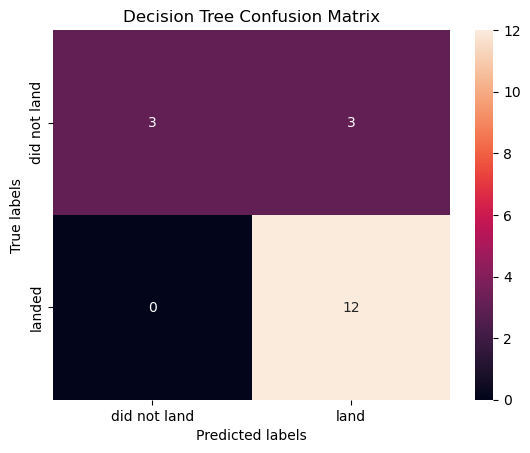

In [34]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat, name = 'Decision Tree')

In [35]:
tree_results_df = pd.DataFrame([[best_estimator, best_params, accuracy, train_score, test_score,  precision, recall, f1]],
                          columns=['best estimator', 'best parameters', 'accuracy', 'train score', 'test score', 'precision', 'recall', 'f1 score'])
tree_results_df.index = ['decision tree']
tree_results_df

,best estimator,best parameters,accuracy,train score,test score,precision,recall,f1 score
decision tree,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.866667,0.861111,0.833333,0.8,1.0,0.888889


> Decision Tree model has worst results compared to logistic regression and SVM with three false positive to consider.

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [37]:
knn_cv = GridSearchCV(KNN,
                     parameters,
                     cv=10)

knn_cv.fit(X, Y)
knn_cv.best_estimator_

KNeighborsClassifier(p=1)

## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [38]:
best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1 = calculate_metrics(knn_cv, X_train, X_test, Y_train, Y_test)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
accuracy : 0.8444444444444444


In [39]:
print("train score: {}".format(np.round(train_score, 4)))
print("test score: {}".format(np.round(test_score, 4)))

train score: 0.875
test score: 0.9444


We can plot the confusion matrix


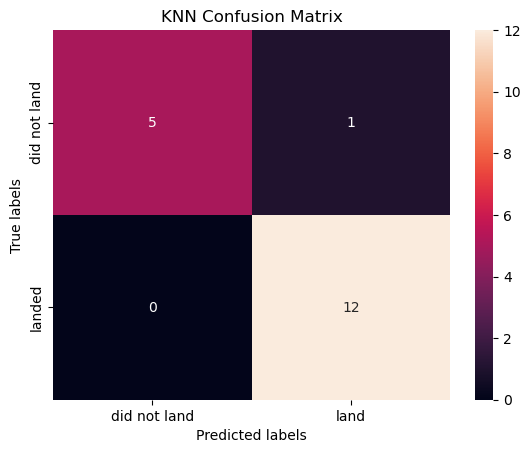

In [40]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat, name='KNN')

In [41]:
knn_results_df = pd.DataFrame([[best_estimator, best_params, accuracy, train_score, test_score, precision, recall, f1]],
                          columns=['best estimator', 'best parameters', 'accuracy', 'train score', 'test score', 'precision', 'recall', 'f1 score'])
knn_results_df.index = ['knn']
knn_results_df

,best estimator,best parameters,accuracy,train score,test score,precision,recall,f1 score
knn,KNeighborsClassifier(p=1),"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.844444,0.875,0.944444,0.923077,1.0,0.96


> The K-Neighbors Classifier achieve the same results in the prediction as the Logistic Regression and SVM

## TASK  12


Find the method performs best:


In [42]:
df_results = (np.round(pd.concat([logreg_results, svm_results_df, tree_results_df, knn_results_df]),3)
              .reset_index()
              .rename(columns={'index':'model'})
             )

df_results

,model,best estimator,best parameters,accuracy,train score,test score,precision,recall,f1 score
0,logistic regression,LogisticRegression(C=0.01),"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.822,0.875,0.944,0.923,1.0,0.960
1,svm,"SVC(gamma=0.03162277660168379, kernel='sigmoid')","{'C': 1.0, 'gamma': 0.03162277660168379, 'kern...",0.822,0.861,0.944,0.923,1.0,0.960
2,decision tree,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.867,0.861,0.833,0.800,1.0,0.889
3,knn,KNeighborsClassifier(p=1),"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}",0.844,0.875,0.944,0.923,1.0,0.960


From the above table, we can see that in terms of prediction results, i.e. test score, precision, recall and f1 score, Logistic Regression, SVM and KNN outperform a Decision Tree model. The preferred predictive model given the current data is **Logistic Regression** for the following reasons:
1. Logistic regression has the advantage of being very simple and easy to impement, not requiring to much computational resources. On the other hand, the highest train score that achieve with respect to the other models, could be an indication of oversampling: it is going to perform very well on the training set while losing generalization (i.e. new sample data)
2. Decision Tree shows a good `accuracy` for the estimated paramenters. This can be an indication of good generalization for future sample points. Decision Trees are good models because they can also highlight what are the factors exaplining the performances and so used to understand the cause for which a launch can be succesfull or not. They are computationally heavier than a Logistic Regression but still manageble with respect to a KNN model.
3. KNN achieve the same results of Logistic Regression and SVM, but its the more "expensive" one as already mentioned in the above points

## Data Plots

In [43]:
df_results_plot = df_results[['model','train score', 'test score', 'precision', 'recall', 'f1 score']]

In [44]:
df_results_plot

,model,train score,test score,precision,recall,f1 score
0,logistic regression,0.875,0.944,0.923,1.0,0.960
1,svm,0.861,0.944,0.923,1.0,0.960
2,decision tree,0.861,0.833,0.800,1.0,0.889
3,knn,0.875,0.944,0.923,1.0,0.960


In [45]:
df_results_plot_long = df_results_plot.melt(id_vars=['model'],
                                            value_vars=['train score', 'test score', 'precision', 'recall', 'f1 score'],
                                            var_name = 'metric',
                                            value_name = 'value')

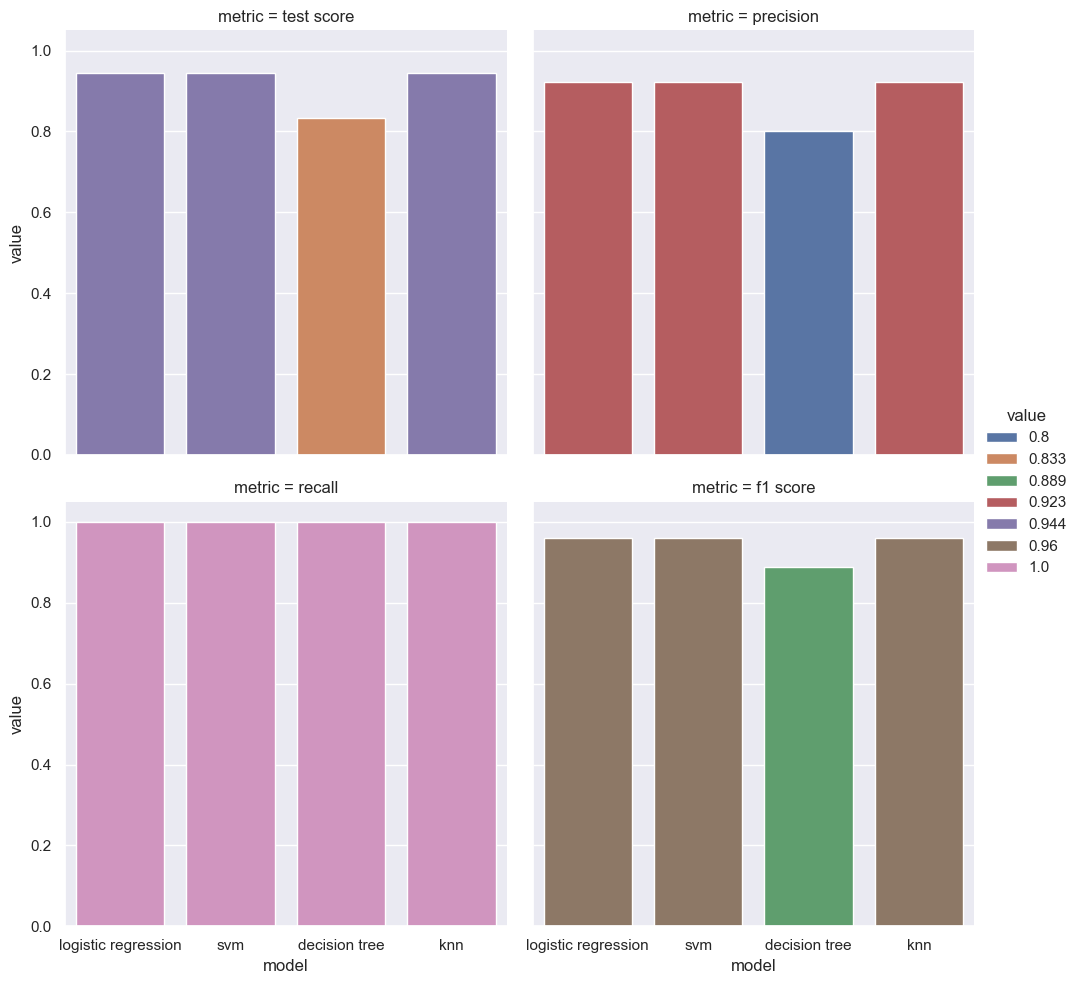

In [46]:
sns.set(style="darkgrid")

sns.catplot(
    data = df_results_plot_long[df_results_plot_long['metric'] != 'train score'],
    x = 'model',
    y = 'value',
    col = 'metric',
    hue = 'value',
    kind = 'bar',
    col_wrap=2,
    dodge=False
);

plt.savefig('./img/prediction_score.png')

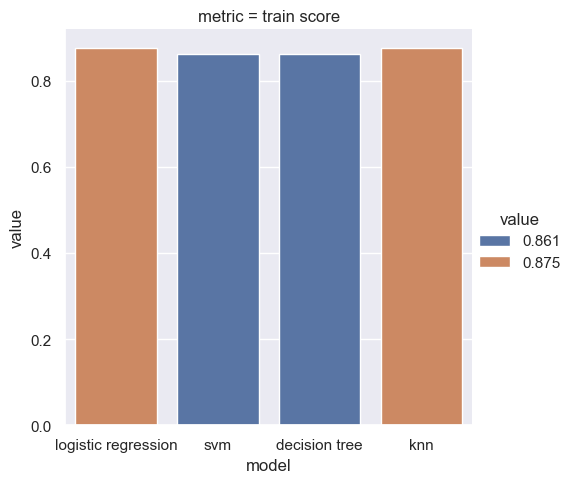

In [47]:
sns.set(style="darkgrid")

sns.catplot(
    data = df_results_plot_long[df_results_plot_long['metric'] == 'train score'],
    x = 'model',
    y = 'value',
    col = 'metric',
    hue = 'value',
    kind = 'bar',
    dodge=False
);

plt.savefig('./img/train_score.png')

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
